# Exploratory Data Analysis of Weather in Illinois

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL queries were run in the Google BigQuery console as shown below in the next two images and the resulting datasets were saved to another BigQuery table within a personal project ID.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

In [16]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.cwd() / "secrets" / "my_credentials.json")

In [17]:
temp_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """
temp_data = pd.read_gbq(temp_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard")

Downloading:   0%|          |

In [18]:
temp_data.drop(['id', 'state', 'qflag'], axis = 1, inplace = True)
temp_data = temp_data[["date", "name", "element", "value", "latitude", "longitude"]]

In [19]:
temp_data_pivot = temp_data.pivot(columns = "element", values = "value")

In [20]:
temp_data = pd.concat([temp_data, temp_data_pivot], axis = 1)
temp_data.drop(["element", "value"], axis = 1, inplace = True)

In [21]:
temp_data.rename(columns = {"TMAX": "TMAX_degC", "TAVG": "TAVG_degC", "TMIN": "TMIN_degC", "TOBS": "TOBS_degC"}, inplace = True)

In [22]:
temp_data["TMAX_degC"] = temp_data["TMAX_degC"] / 10
temp_data["TMIN_degC"] = temp_data["TMIN_degC"] / 10
temp_data["TAVG_degC"] = temp_data["TAVG_degC"] / 10
temp_data["TOBS_degC"] = temp_data["TOBS_degC"] / 10

In [23]:
temp_data["TMAX_degF"] = 9/5 * temp_data["TMAX_degC"] + 32
temp_data["TMIN_degF"] = 9/5 * temp_data["TMIN_degC"] + 32
temp_data["TAVG_degF"] = 9/5 * temp_data["TAVG_degC"] + 32
temp_data["TOBS_degF"] = 9/5 * temp_data["TAVG_degC"] + 32

<Axes: xlabel='date'>

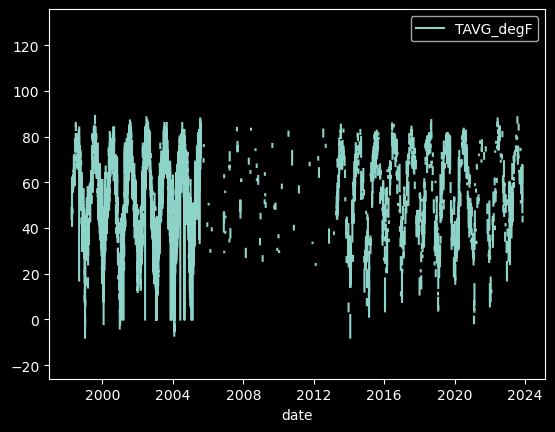

In [24]:
temp_data.plot(kind = "line", x = "date", y = "TAVG_degF")